# Heart Disease Prediction - Kaggle Playground Series S6E2

Este notebook desenvolve modelos de machine learning para prever a **probabilidade de doença cardíaca** a partir de dados sintéticos gerados por deep learning, contendo informações demográficas, clínicas e de estilo de vida.

---

## 🎯 Objetivo

Prever a probabilidade de um indivíduo ter **Heart Disease** (doença cardíaca) com base em features clínicas e demográficas. O modelo deve retornar uma probabilidade contínua entre 0 e 1, onde valores mais altos indicam maior risco de doença cardíaca.

---

## 📊 Métrica de Avaliação

As submissões serão avaliadas pela **ROC-AUC (Area Under the Receiver Operating Characteristic Curve)**.

- **O que é?** Mede a capacidade do modelo de distinguir entre pessoas com e sem doença cardíaca em diferentes thresholds de classificação
- **Range**: 0 a 1 (quanto mais próximo de 1, melhor)
- **Vantagem**: Métrica robusta para classificação binária, especialmente útil quando as classes podem estar desbalanceadas
- **Interpretação**:
  - AUC = 0.5 → Modelo aleatório (sem poder preditivo)
  - AUC = 0.7-0.8 → Boa discriminação
  - AUC = 0.8-0.9 → Excelente discriminação
  - AUC > 0.9 → Discriminação excepcional

**Formato de Submissão:**
```csv
id,Heart Disease
630000,0.2
630001,0.3
630002,0.1


# 1. ENVIRONMENT SETUP

-------

## 1.1 Instalação de dependências


In [2]:
# Installation of all necessary dependencies
!pip install -q optuna xgboost lightgbm catboost scikit-learn pandas numpy matplotlib seaborn tqdm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1.2 Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42 #Random seed para repordutibilidade
np.random.seed(RANDOM_STATE)


## 1.3 Data Loading


In [4]:
test = pd.read_csv("data/test.csv") #carega dados de test
train = pd.read_csv("data/train.csv") #carrega dados de treino

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nTotal records: {train.shape[0] + test.shape[0]:,}") #quantidade todais de dados

Train shape: (630000, 15)
Test shape: (270000, 14)

Total records: 900,000


In [5]:
train.head() #primeiras 5 linhas

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [6]:
train.columns

Index(['id', 'Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol',
       'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina',
       'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium',
       'Heart Disease'],
      dtype='object')

| Feature (Coluna) | Descrição | Tipo de Dado | Detalhes dos Valores |
| :--- | :--- | :--- | :--- |
| **Age** | Idade do paciente (em anos) | Numérico/Inteiro | Idade em anos. |
| **Sex** | Gênero do paciente | Categórico/Binário | 1 = Masculino<br>0 = Feminino |
| **Chest pain type** | Tipo de dor no peito | Categórico | 1 = Angina típica<br>2 = Angina atípica<br>3 = Dor não anginosa<br>4 = Assintomática |
| **BP** | Pressão arterial em repouso (mm Hg) | Numérico/Inteiro | Valor da pressão arterial em mm Hg. |
| **Cholesterol** | Nível de colesterol sérico (mg/dL) | Numérico/Inteiro | Valor do colesterol em mg/dL. |
| **FBS over 120** | Glicemia em jejum > 120 mg/dL | Categórico/Binário | 1 = Verdadeiro<br>0 = Falso |
| **EKG results** | Resultados de eletrocardiograma em repouso | Categórico | 0 = Normal<br>1 = Anormalidade da onda ST-T<br>2 = Hipertrofia ventricular esquerda |
| **Max HR** | Frequência cardíaca máxima alcançada | Numérico/Inteiro | Batimentos máximos alcançados. |
| **Exercise angina** | Angina induzida por exercício | Categórico/Binário | 1 = Sim<br>0 = Não |
| **ST depression** | Depressão do ST induzida por exercício em relação ao repouso | Numérico/Decimal | Valor da depressão do segmento ST. |
| **Slope of ST** | Inclinação do segmento ST do pico de exercício | Categórico | Descreve a inclinação do pico do exercício ST. |
| **Number of vessels fluro** | Número de vasos principais (0-3) coloridos por fluoroscopia | Numérico/Inteiro | Quantidade de vasos (0 a 3). |
| **Thallium** | Resultado do teste de estresse com Tálio (indicador médico categórico) | Categórico | Indicador médico categórico. |
| **Heart Disease** | Variável alvo | Categórico (Alvo) | Presence = Doença cardíaca detectada<br>Absence = Sem doença cardíaca |

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 non-null  int64  
 14  Hear

In [8]:
print(test.isnull().sum())

id                         0
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
dtype: int64


- Vemos a ausência de dados nulos, não necessitando de tratamento nessa etapa.

In [9]:
train.describe() #estatisticas básicas

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,54.136706,0.714735,3.312752,130.497433,245.011814,0.079987,0.981660,152.816763,0.273725,0.716028,1.455871,0.451040,4.618873
std,181865.479132,8.256301,0.451541,0.851615,14.975802,33.681581,0.271274,0.998783,19.112927,0.445870,0.948472,0.545192,0.798549,1.950007
min,0.000000,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,157499.750000,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,314999.500000,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000
75%,472499.250000,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000
max,629999.000000,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


- Separar os tipos de features e também o target(variavel alvo)

In [10]:
target = "Heart Disease"
id_col = "id"

numeric_features = [
    "Age",
    "BP",
    "Cholesterol",
    "Max HR",
    "ST depression"
]

categorical_features = [
    "Sex",
    "Chest pain type",
    "FBS over 120",
    "EKG results",
    "Exercise angina",
    "Slope of ST",
    "Number of vessels fluro",
    "Thallium"
]

print(f"Target variable: '{target}'")
print(f"ID column: '{id_col}'")
print(f"\nNumeric features ({len(numeric_features)}): {numeric_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")
print(f"\nTotal features: {len(numeric_features) + len(categorical_features)}")


Target variable: 'Heart Disease'
ID column: 'id'

Numeric features (5): ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

Categorical features (8): ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium']

Total features: 13


In [11]:
x_train = train.drop([id_col, target], axis=1) #x sendo os dados de treino sem o id (nao ajudara em nada no modelo e o target)
y_train = train[target] #y sendo o target
X_test = test.drop([id_col], axis=1) #x_teste sendo os dados sem ID, dados de teste não tem o targe (A nossa missão é descobrir)

print(x_train.shape, y_train.shape, X_test.shape)

(630000, 13) (630000,) (270000, 13)


# 2. EDA

------------------

## 2.1 Análise da variável Alvo

Heart Disease
Absence     55.166032
Presence    44.833968
Name: proportion, dtype: float64


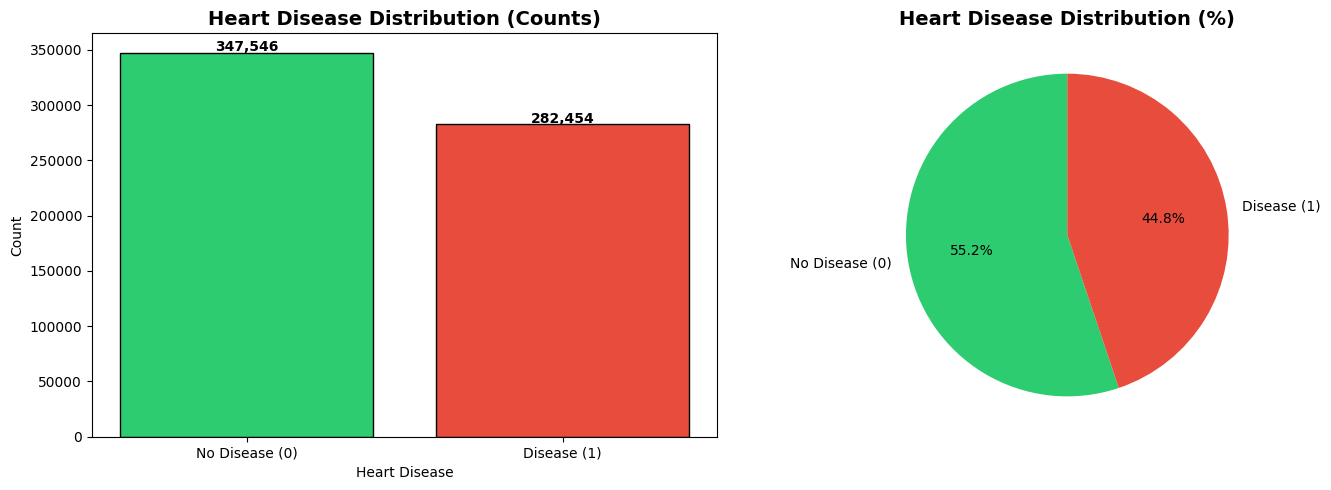

In [12]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
target_counts = y_train.value_counts() #contagem de dados target, devolverá a contagem de pessoas com doença e sem doença
target_pct = y_train.value_counts(normalize=True) * 100 #normaliza a contagem onde a soma total é 100%
print(target_pct)

axes[0].bar(target_counts.index, target_counts.values, color=['#2ecc71', '#e74c3c'], edgecolor='black') #Grafico de barra com os valores absoluotos de contagem
axes[0].set_title('Heart Disease Distribution (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Heart Disease')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No Disease (0)', 'Disease (1)'])
for i, v in enumerate(target_counts.values): #para aparecer o numero nas barras
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

axes[1].pie(target_counts.values, labels=['No Disease (0)', 'Disease (1)'], #grafico de pizza com os valores normalizados
            autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#e74c3c'])
axes[1].set_title('Heart Disease Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


Essa proporção é ideal para o treinamento de modelos preditivos, pois a pequena diferença entre as classes minimiza o risco de viés e garante representatividade para ambos os grupos.

## 2.2. Correlação entre features numéricas e target


Unique values: ['Presence' 'Absence'] -> [0 1]


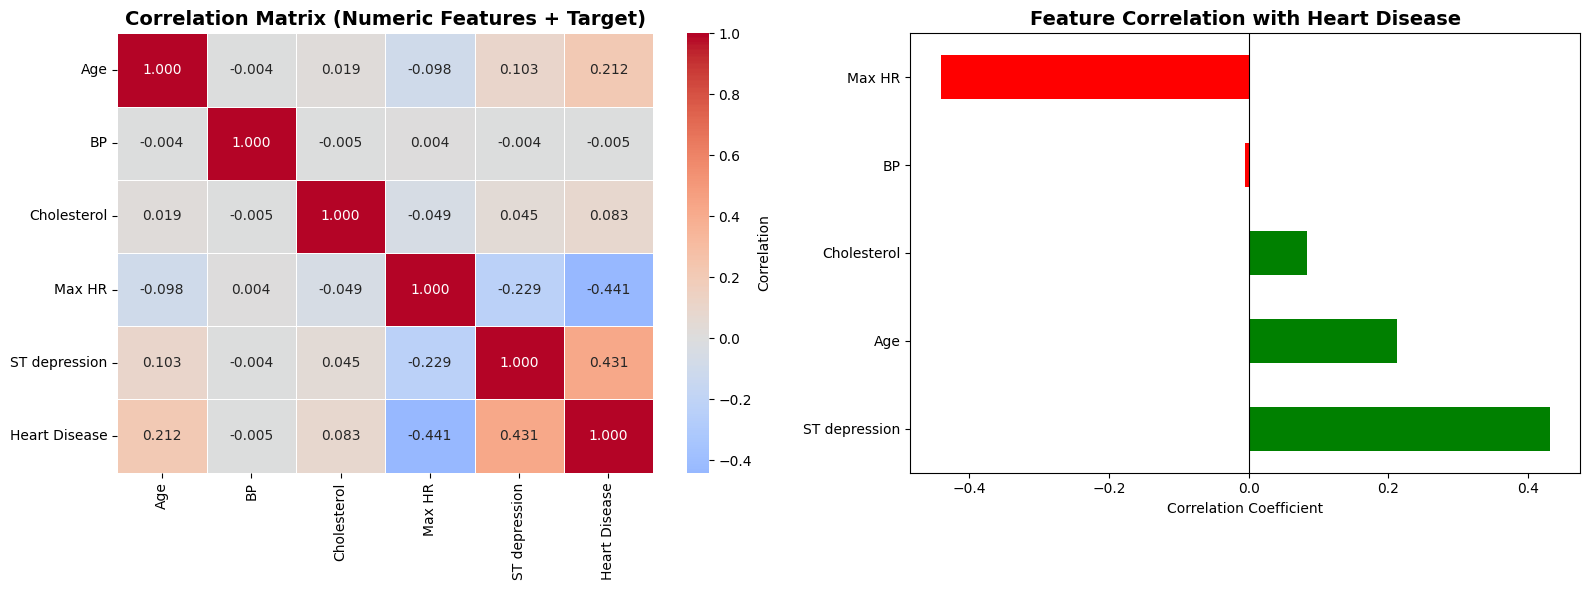

In [13]:
numeric_data = x_train[numeric_features].copy()
if y_train.dtype == 'object': #convert para dados numericas doneças ou sem doenças
    y_numeric = y_train.map({'Absence': 0, 'Presence': 1}).values #convert 0 e 1
    print(f"Unique values: {y_train.unique()} -> {np.unique(y_numeric)}")
else:
    y_numeric = y_train


numeric_data['Heart Disease'] = y_numeric
correlation_matrix = numeric_data.corr() #matriz de correlação
target_corr = correlation_matrix['Heart Disease'].drop('Heart Disease').sort_values(ascending=False)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            ax=axes[0], linewidths=0.5, cbar_kws={'label': 'Correlation'})
axes[0].set_title('Correlation Matrix (Numeric Features + Target)', fontsize=14, fontweight='bold')


target_corr.plot(kind='barh', ax=axes[1], color=['green' if x > 0 else 'red' for x in target_corr]) #para saber quas influenciam em doenças
axes[1].set_title('Feature Correlation with Heart Disease', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Correlation Coefficient')
axes[1].axvline(0, color='black', linewidth=0.8)


plt.tight_layout()
plt.show()

##  2.3 Categorical Features vs Target Analysis

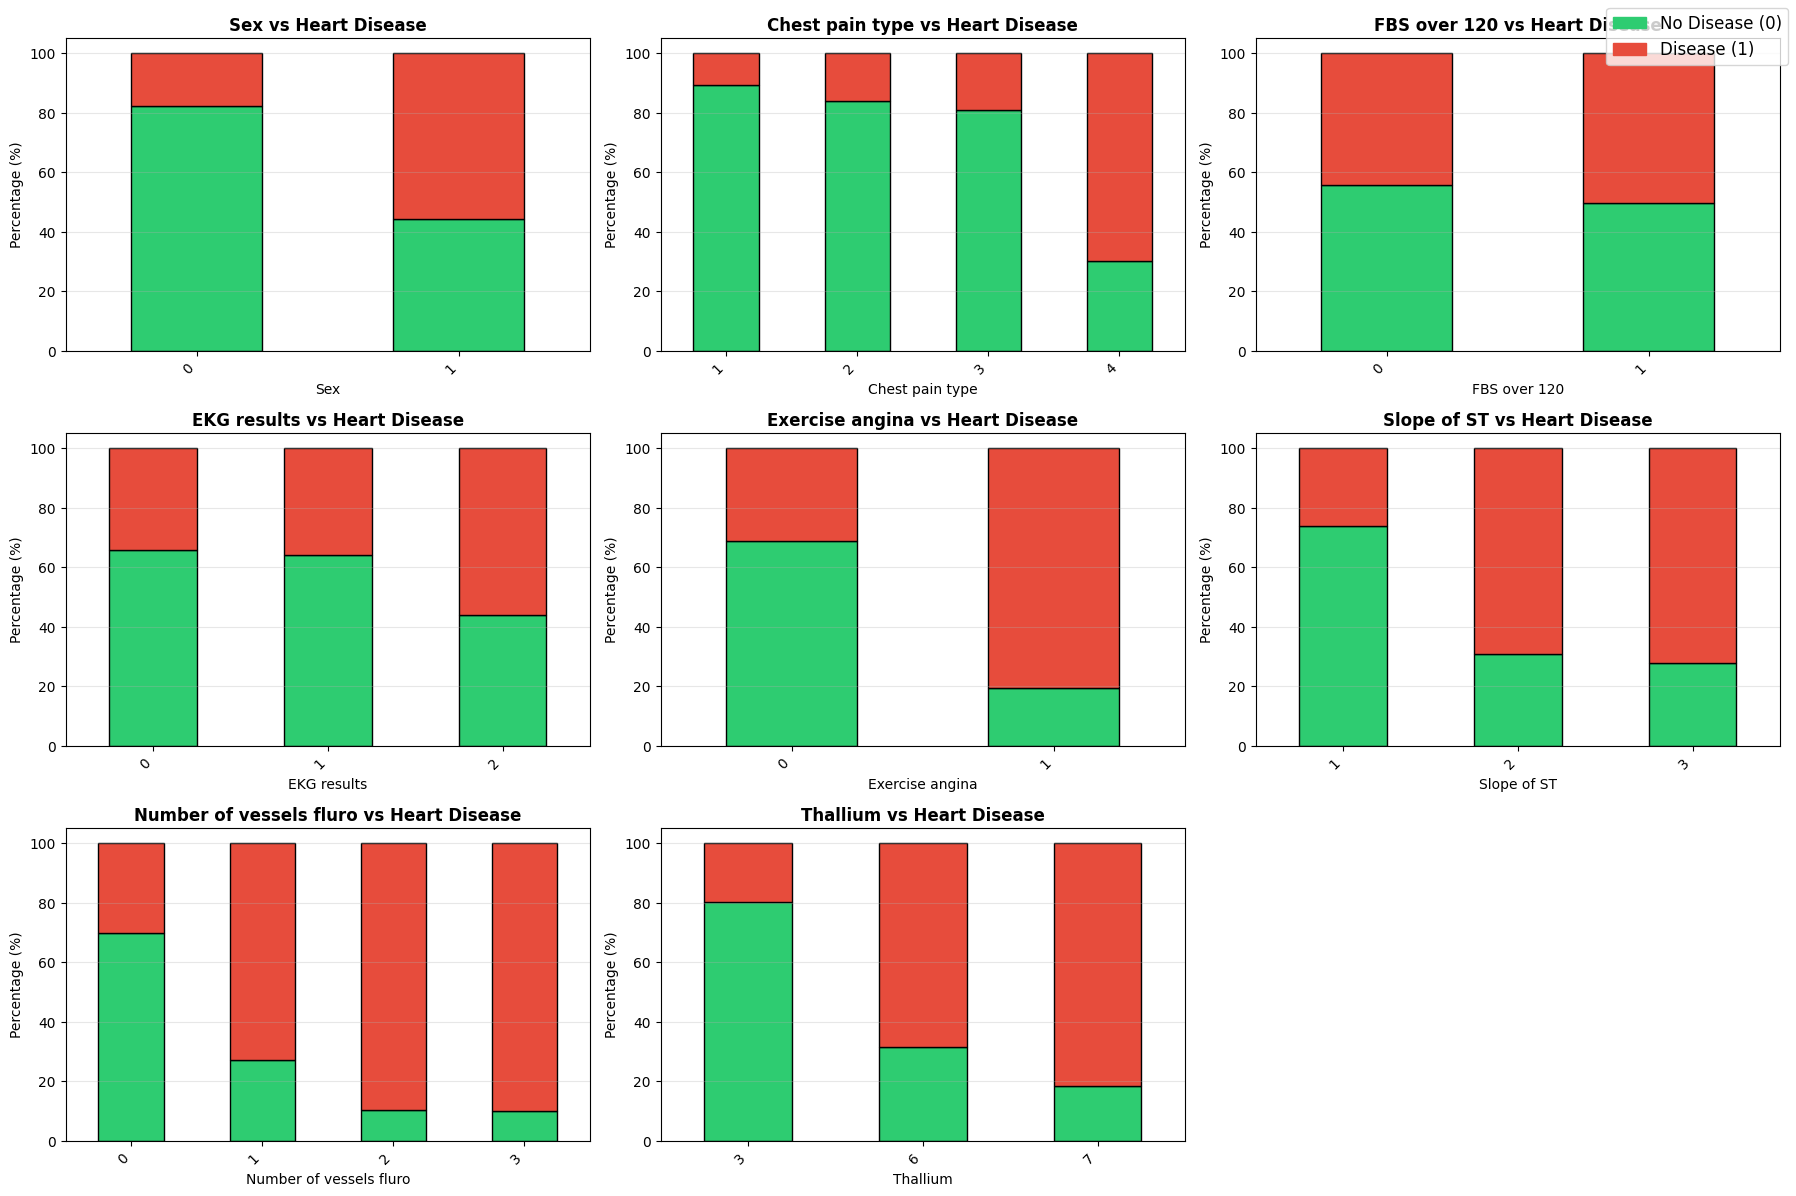

In [14]:
n_categorical = len(categorical_features) #quantidade de variaveis categorias
n_cols = 3
n_rows = (n_categorical + n_cols - 1) // n_cols #quantidade de linha para plots , 3 linhas de graficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4)) #subplot 3x3
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    ax = axes[idx]
    cross_tab = pd.crosstab(x_train[feature], y_train, normalize='index') * 100 #Cruza os dados para contar quantos pacientes existem em cada combinação
    #Transforma os números brutos em proporções dentro de cada categoria. 
    cross_tab.plot(kind='bar', stacked=True, ax=ax, color=['#2ecc71', '#e74c3c'],  #plot das barras
                   edgecolor='black', legend=False)
    ax.set_title(f'{feature} vs Heart Disease', fontweight='bold')#titulo grafico
    ax.set_xlabel(feature)
    ax.set_ylabel('Percentage (%)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(alpha=0.3, axis='y')

for idx in range(n_categorical, len(axes)):
    axes[idx].axis('off')

handles = [plt.Rectangle((0,0),1,1, color='#2ecc71'), plt.Rectangle((0,0),1,1, color='#e74c3c')]#cores legenda
labels = ['No Disease (0)', 'Disease (1)'] #labels leganda
fig.legend(handles, labels, loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

### Análise das Variáveis Categóricas (Incidência de Doença)

* **Sex:** Apresenta uma disparidade significativa; o grupo masculino (1) demonstra uma taxa de incidência de doença consideravelmente superior ao grupo feminino (0), sendo um forte divisor demográfico no modelo.
* **Chest pain type:** O tipo 4 (Assintomática) é o indicador mais crítico, apresentando as maiores taxas de presença da doença, enquanto o tipo 2 (Angina atípica) apresenta a menor incidência proporcional.
* **FBS over 120:** Embora indique risco metabólico, a taxa de doença entre quem tem glicemia alta (>120) é muito similar à de quem tem glicemia normal, sugerindo ser o preditor categórico de menor impacto individual.
* **EKG results:** Pacientes com resultados tipo 2 (Hipertrofia ventricular esquerda) mostram uma probabilidade de doença cardíaca visivelmente maior em comparação aos que apresentam resultados normais (0).
* **Exercise angina:** Um dos preditores mais binários; a presença de angina induzida por exercício (1) eleva drasticamente a taxa de doença cardíaca positiva em comparação a quem não manifesta o sintoma (0).
* **Slope of ST:** A inclinação descendente ou plana no teste de esforço está fortemente correlacionada à presença da doença, enquanto a inclinação ascendente é um forte indicador de ausência (saúde cardíaca).
* **Thallium:** Variável de alta especificidade; o resultado "Reversível" apresenta uma taxa de doença muito superior ao resultado "Normal", tornando-se um dos filtros mais precisos para o diagnóstico final.

# 3. DATA PREPROCESSING

---------------

- Vimos acima que somente o Target(y) necessita de transformação para numero, pois ele tem presence e absence e não valores númericos como 0 e 1

In [15]:
y_train.head()

0    Presence
1     Absence
2     Absence
3     Absence
4    Presence
Name: Heart Disease, dtype: object

## 3.1 Categorical Variables Transformation


In [16]:
y_train_transformed = y_train.map({'Absence': 0, 'Presence': 1}).values #absence tera valor 0 e presença valor
print(f"\nTarget shape: {y_train_transformed.shape}")
print(f"Unique values: {np.unique(y_train_transformed)}")
print(f"Distribution: {np.bincount(y_train_transformed)}")


Target shape: (630000,)
Unique values: [0 1]
Distribution: [347546 282454]


In [17]:
y_train_transformed[:10]  # Primeiros 10 valores

array([1, 0, 0, 0, 1, 1, 1, 0, 0, 0])

- vemos agora que so tem valores 0 e 1, ideal para o modelo que queremos trabalhar.

## 3.2 Feature Engineering


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()# Treinar regressão logística simples
X_scaled = scaler.fit_transform(x_train[numeric_features]) #normaliza dados numerricos
lr = LogisticRegression(random_state=42)
lr.fit(X_scaled, y_train_transformed) #treina modelo

# Extrair coeficientes para usar na criaçao e features
coefficients = dict(zip(numeric_features, lr.coef_[0]))
print("Coeficientes aprendidos:")
for feat, coef in coefficients.items():
    print(f"  {feat}: {coef:.4f}")

Coeficientes aprendidos:
  Age: 0.4244
  BP: -0.0044
  Cholesterol: 0.1441
  Max HR: -1.0234
  ST depression: 0.9945


In [19]:
def create_features(df):
    df = df.copy()
    eps = 1e-6
    
    # 1. Polynomial features (Square)
    df["Age_sq"] = df["Age"] ** 2
    df["Cholesterol_sq"] = df["Cholesterol"] ** 2
    df["Max HR_sq"] = df["Max HR"] ** 2
    df["ST depression_sq"] = df["ST depression"] ** 2
    
    # 2. Mathematical transformations (Log/Sqrt)
    df["log_age"] = np.log1p(df["Age"])
    df["log_cholesterol"] = np.log1p(df["Cholesterol"])
    df["log_st_depression"] = np.log1p(df["ST depression"])
    df["sqrt_age"] = np.sqrt(df["Age"])
    df["sqrt_cholesterol"] = np.sqrt(df["Cholesterol"])
    df["sqrt_maxhr"] = np.sqrt(df["Max HR"])
    
    # 3. Interactions (Multiplications)
    df["age_x_st_depression"] = df["Age"] * df["ST depression"]
    df["maxhr_x_st_depression"] = df["Max HR"] * df["ST depression"]
    df["age_x_maxhr"] = df["Age"] * df["Max HR"]
    df["age_x_cholesterol"] = df["Age"] * df["Cholesterol"]
    df["cholesterol_x_st_depression"] = df["Cholesterol"] * df["ST depression"]

    # 4. Ratios (Divisions)
    df["cholesterol_per_age"] = df["Cholesterol"] / (df["Age"] + eps)
    df["maxhr_per_age"] = df["Max HR"] / (df["Age"] + eps)
 
    # 5. Differences (Deviation from mean)
    df["age_diff_mean"] = df["Age"] - df["Age"].mean()
    df["cholesterol_diff_mean"] = df["Cholesterol"] - df["Cholesterol"].mean()
    df["maxhr_diff_mean"] = df["Max HR"] - df["Max HR"].mean()
    
    # 6. Binning (Discretization)
    df["age_bin"] = pd.cut(df["Age"], bins=[-1, 40, 50, 60, 100], labels=False)
    df["cholesterol_bin"] = pd.cut(df["Cholesterol"], bins=[-1, 200, 240, 280, 600], labels=False)
    df["maxhr_bin"] = pd.cut(df["Max HR"], bins=[-1, 100, 130, 160, 250], labels=False)
    df["st_bin"] = pd.cut(df["ST depression"], bins=[-1, 0.5, 1.5, 3.0, 10], labels=False)
    
    # 7. Boolean Flags (Risk factors)
    df["elderly"] = (df["Age"] >= 60).astype(int)
    df["high_cholesterol"] = (df["Cholesterol"] >= 240).astype(int)
    df["high_st_depression"] = (df["ST depression"] > 2.0).astype(int)
    
    # 8. Risk Scores
    df["learned_risk_score"] = (
        df["Age"] * 0.4244 +
        df["BP"] * (-0.0044) +
        df["Cholesterol"] * 0.1441 +
        df["Max HR"] * (-1.0234) +
        df["ST depression"] * 0.9945
    )
    
    df["risk_factors_count"] = (
        df["elderly"] + 
        df["high_cholesterol"] + 
        df["high_st_depression"]
    )
    
    return df


In [20]:
x_train_features = create_features(x_train)
X_test_features  = create_features(X_test)

print(f"Original features: {x_train_features.shape[1]}")
print(f"Features created: {x_train_features.shape[1] - x_train.shape[1]}")
print(f"Total features: {x_train_features.shape[1]}")

Original features: 42
Features created: 29
Total features: 42


## 3.3 Feature Quality Analysis


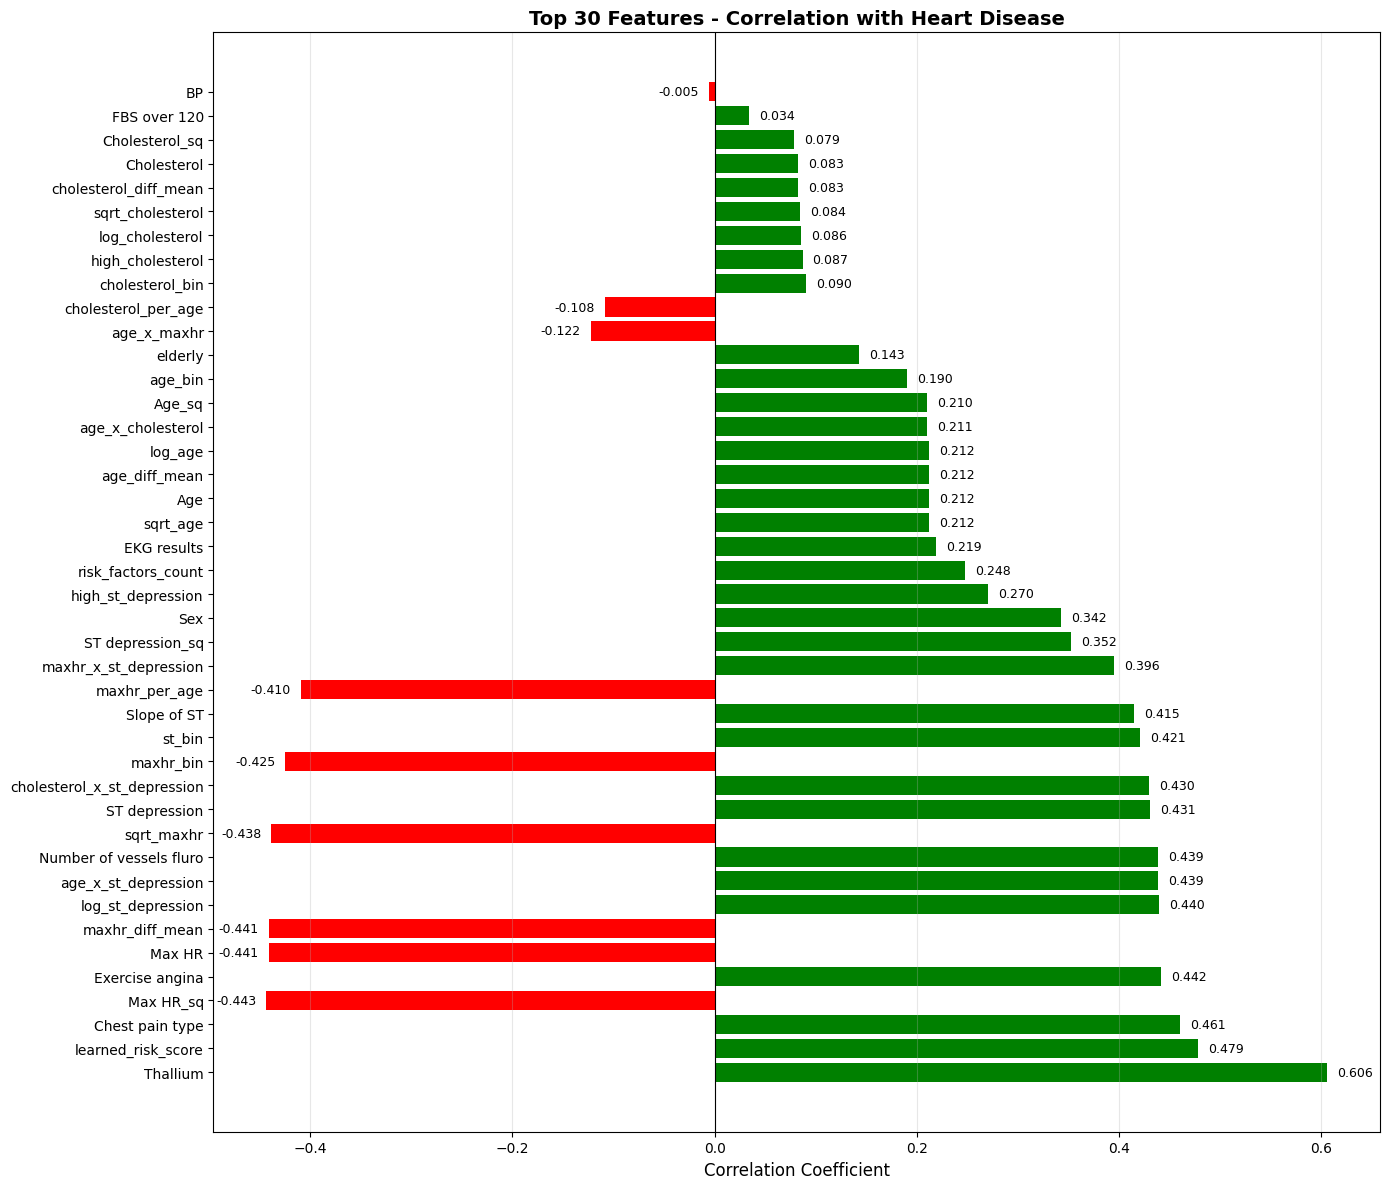

In [21]:
# Correlation with target
df_corr = x_train_features.copy()
df_corr['target'] = y_train_transformed
corr_target = df_corr.corr(numeric_only=True)['target'].drop('target') #calcula correlação com o target
corr_sorted = corr_target.abs().sort_values(ascending=False)

#Visualization Features
height = 12
plt.figure(figsize=(14, height))

top_corr = corr_target.loc[corr_sorted.head(42).index]
colors = ['green' if x > 0 else 'red' for x in top_corr.values]

bars = plt.barh(range(len(top_corr)), top_corr.values, color=colors)
plt.yticks(range(len(top_corr)), top_corr.index)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.title('Top 30 Features - Correlation with Heart Disease', fontsize=14, fontweight='bold')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(alpha=0.3, axis='x')

for i, (feat, val) in enumerate(zip(top_corr.index, top_corr.values)):
    plt.text(val + 0.01 if val > 0 else val - 0.01, i, f'{val:.3f}', 
             va='center', ha='left' if val > 0 else 'right', fontsize=9)
plt.tight_layout()
plt.show()


## 3.4. Model Evaluation Function (Cross-Validation)


In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
import numpy as np

def evaluate_model_cv(model, X, y, cv=5): #modelo a ser avaliado, x sendo as features, y sendo o targe cv = 5 numero de divisoes para validação cruzada
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42) #mantém a proporção de classes em cada fold
    #shuffle=True: embaralha os dados antes de dividir
    roc_auc_scores = []
    
    for train_idx, val_idx in skf.split(X, y): #loop da divisao dos dados entre treino e validação
        # Split data
        if hasattr(X, 'iloc'):  # If DataFrame
            X_train_fold = X.iloc[train_idx] #array com os índices das linhas para x de treino
            X_val_fold = X.iloc[val_idx] # array com os índices das linhas para x de validação
        else:  # If numpy array
            X_train_fold = X[train_idx]
            X_val_fold = X[val_idx]
        
        y_train_fold = y[train_idx] #para separação do dados y de treino
        y_val_fold = y[val_idx] ##para separação do dados y de validaçãp
        model_fold = clone(model) #Cria uma cópia independente para não contaminar entre folds
        
        model_fold.fit(X_train_fold, y_train_fold)#treino apartir dop modelo e os dados separados
        y_pred_proba = model_fold.predict_proba(X_val_fold)[:, 1] # Predição probabilidade aparte dos dados de x de validação para prever o y de vlaidação
        roc_auc = roc_auc_score(y_val_fold, y_pred_proba) # Calculate ROC-AUC
        roc_auc_scores.append(roc_auc) #adiciona no vetor acima para armazenar os valores3
    
    return np.array(roc_auc_scores)

# 4. Models

## 4.1. Random Florest

------------

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Simple Random Forest for testing
rf_model = RandomForestClassifier(
    n_estimators=200,#Quantidade de arvores sendo os valores do vetor definido acima
    max_depth=10, #profundidade mais alta na arvore
    random_state=42,
    n_jobs=-1 #usa todos nucleos disponiveis
)

roc_scores = evaluate_model_cv(rf_model, x_train_features, y_train_transformed, cv=5) #chama função de validação cruzada
#retornaa a TODOS os 5 scores (um de cada fold)
for fold, score in enumerate(roc_scores, 1): #Percorre o array `roc_scores`
    #enumerate` adiciona um contador que começa em 1 (não 0)
    #Em cada iteração: `fold` = número do fold, `score` = valor do ROC-AUC
    print(f"  Fold {fold}: {score:.4f}")
print(f"\nMean ROC-AUC: {roc_scores.mean():.4f}")

In [ ]:
rf_model.fit(x_train_features, y_train_transformed) #treina o modelo para os nosso dados de competição
y_test_proba = rf_model.predict_proba(X_test_features)[:, 1] #faz a preidção apartir dos dados de teste separados para competição
#devolve o target de teste para submissao na competição
submission_rf = pd.DataFrame({ #para submissao 
    'id': test['id'], 
    'Heart Disease': y_test_proba #target test
})

submission_filename = 'submission_RF.csv' #nome do arquivo CSV
submission_rf.to_csv(submission_filename, index=False) #salva arquivo CSV

## 4.2 XGBoost com melhores parâmetros do Optuna

----------

In [ ]:
from xgboost import XGBClassifier

# Melhores parâmetros do Optuna (Trial 12 - ROC-AUC: 0.9553)
best_params = {
    'n_estimators': 1846,
    'max_depth': 4,
    'learning_rate': 0.023505567215335334,
    'subsample': 0.8964398127319203,
    'colsample_bytree': 0.7461871992811935,
    'min_child_weight': 8,
    'reg_alpha': 0.0013530801725837789,
    'reg_lambda': 0.04149905466702172,
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'logloss'
}

xgb_model = XGBClassifier(**best_params)

roc_scores = evaluate_model_cv(xgb_model, x_train_features, y_train_transformed, cv=5)

for fold, score in enumerate(roc_scores, 1):
    print(f"  Fold {fold}: {score:.4f}")
print(f"\nMean ROC-AUC: {roc_scores.mean():.4f}")

In [ ]:
xgb_model.fit(x_train_features, y_train_transformed #para os dados de treino da competição
y_test_proba_xgb = xgb_model.predict_proba(X_test_features)[:, 1] #preve o targe de teste apartir das features de teste

submission_xgb = pd.DataFrame({ ## Cria o DataFrame de submissão
    'id': test['id'], 
    'Heart Disease': y_test_proba_xgb
})

submission_filename_xgb = 'submission_XGBoost.csv' # Salva o arquivo CSV
submission_xgb.to_csv(submission_filename_xgb, index=False)

## 4.3 LightGBM com melhores parâmetros do Optuna

----------

In [ ]:
from lightgbm import LGBMClassifier

# Melhores parâmetros do Optuna (Trial 9 - ROC-AUC: 0.9552)
best_params_lgbm = {
    'n_estimators': 2358,
    'max_depth': 6,
    'learning_rate': 0.01591491356433613,
    'subsample': 0.6755577155730306,
    'colsample_bytree': 0.6435299051427048,
    'min_child_weight': 9,
    'reg_alpha': 2.3012875988294404e-08,
    'reg_lambda': 9.907582441702714e-05,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

lgbm_model = LGBMClassifier(**best_params_lgbm)

roc_scores = evaluate_model_cv(lgbm_model, x_train_features, y_train_transformed, cv=5)

for fold, score in enumerate(roc_scores, 1):
    print(f"  Fold {fold}: {score:.4f}")
print(f"\nMean ROC-AUC: {roc_scores.mean():.4f}")

In [ ]:
lgbm_model.fit(x_train_features, y_train_transformed) #treina o modelo com todos os dados de treino
y_test_proba_lgbm = lgbm_model.predict_proba(X_test_features)[:, 1] #preve o target de teste

submission_lgbm = pd.DataFrame({ # Cria o DataFrame de submissão
    'id': test['id'],
    'Heart Disease': y_test_proba_lgbm
})

submission_filename_lgbm = 'submission_LightGBM.csv' # Salva o arquivo CSV
submission_lgbm.to_csv(submission_filename_lgbm, index=False)

## 4.4 CatBoost com melhores parâmetros do Optuna

----------

In [ ]:
from catboost import CatBoostClassifier

# Melhores parâmetros do Optuna (Trial 13 - ROC-AUC: 0.9554)
best_params_cat = {
    'n_estimators': 4085,
    'max_depth': 4,
    'learning_rate': 0.01822508536770754,
    'subsample': 0.6521983038637353,
    'colsample_bylevel': 0.6015701772085172,
    'min_child_samples': 2,
    'reg_lambda': 2.6510630171760963,
    'random_state': 42,
    'verbose': 0
}

cat_model = CatBoostClassifier(**best_params_cat)

roc_scores = evaluate_model_cv(cat_model, x_train_features, y_train_transformed, cv=5)

for fold, score in enumerate(roc_scores, 1):
    print(f"  Fold {fold}: {score:.4f}")
print(f"\nMean ROC-AUC: {roc_scores.mean():.4f}")

In [ ]:
cat_model.fit(x_train_features, y_train_transformed) #treina o modelo com todos os dados de treino
y_test_proba_cat = cat_model.predict_proba(X_test_features)[:, 1] #preve o target de teste

submission_cat = pd.DataFrame({ # Cria o DataFrame de submissão
    'id': test['id'],
    'Heart Disease': y_test_proba_cat
})

submission_filename_cat = 'submission_CatBoost.csv' # Salva o arquivo CSV
submission_cat.to_csv(submission_filename_cat, index=False)